## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

### Load requirements and data

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, Dropout, 
                          Activation, Conv1D, MaxPooling1D, Flatten, concatenate, Reshape)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback, ModelCheckpoint
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

from scipy import sparse
import time


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Environmental vars

In [2]:
DATADIR = os.getenv('DATADIR')

### Print data version

In [3]:
print('algorithm running on data extracted from content store on {}'.format(DATADIR))

algorithm running on data extracted from content store on /data/2018-03-27


## Hyperparameters

Intuition for POS_RATIO is that it penalises the prediction of zero for everything, which is attractive to the model because the multilabel y matrix is super sparse. 

Increasing POS_RATIO should penalise predicting zeros more.

In [4]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # keras embedding layer output_dim = Dimension of the dense embedding
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function
NUM_WORDS=20000 #keras tokenizer num_words: None or int. Maximum number of words to work with 
#(if set, tokenization will be restricted to the top num_words most common words in the dataset).

### Read in data

In [5]:
train = np.load(os.path.join(DATADIR, 'train_arrays.npz'))

In [6]:
train.files

['x', 'meta', 'title', 'desc', 'y', 'content_id']

In [7]:
x_train = train['x']
meta_train = train['meta'].all().todense()
title_train = train['title'].all().todense()
desc_train = train['desc'].all().todense()
y_train = train['y'].all().todense()

print('x_train.shape = {}'.format(x_train.shape))
print('meta_train.shape = {}'.format(meta_train.shape))
print('title_train.shape = {}'.format(title_train.shape))
print('desc_train.shape = {}'.format(desc_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

x_train.shape = (179166, 1000)
meta_train.shape = (179166, 529)
title_train.shape = (179166, 10000)
desc_train.shape = (179166, 10000)
y_train.shape = (179166, 216)


In [8]:
dev = np.load(os.path.join(DATADIR, 'dev_arrays.npz'))

In [9]:
x_dev = dev['x']
meta_dev = dev['meta'].all().todense()
title_dev = dev['title'].all().todense()
desc_dev = dev['desc'].all().todense()
y_dev = dev['y'].all().todense()

print('x_dev.shape = {}'.format(x_dev.shape))
print('meta_dev.shape = {}'.format(meta_dev.shape))
print('title_dev.shape = {}'.format(title_dev.shape))
print('desc_dev.shape = {}'.format(desc_dev.shape))
print('y_dev.shape = {}'.format(y_dev.shape))

x_dev.shape = (13020, 1000)
meta_dev.shape = (13020, 529)
title_dev.shape = (13020, 10000)
desc_dev.shape = (13020, 10000)
y_dev.shape = (13020, 216)


In [10]:
test = np.load(os.path.join(DATADIR, 'test_arrays.npz'))

In [11]:
x_test = test['x']
meta_test = test['meta'].all().todense()
title_test = test['title'].all().todense()
desc_test = test['desc'].all().todense()
y_test = test['y'].all().todense()

print('x_test.shape = {}'.format(x_test.shape))
print('meta_test.shape = {}'.format(meta_test.shape))
print('title_test.shape = {}'.format(title_test.shape))
print('desc_test.shape = {}'.format(desc_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

x_test.shape = (13022, 1000)
meta_test.shape = (13022, 529)
title_test.shape = (13022, 10000)
desc_test.shape = (13022, 10000)
y_test.shape = (13022, 216)


#### previous shapes in old data 
Shape of x_train: (150870, 1000)
Shape of metax_train: (150870, 436)
Shape of titlex_train: (150870, 10000)
Shape of descx_train: (150870, 10000)
Shape of y_train: (150870, 210)

Shape of x_dev: (9234, 1000)
Shape of meta_dev: (9234, 436)
Shape of titlex_dev: (9234, 10000)
Shape of descx_dev: (9234, 10000)
Shape of y_dev: (9234, 210)

Shape of x_test: (9234, 1000)
Shape of metax_test: (9234, 436)
Shape of titlex_test: (9234, 10000)
Shape of descx_test: (9234, 10000)
Shape of y_test: (9234, 210)

### preparing the Embedding layer


In [12]:
import json
from collections import OrderedDict

def load_tokenizer_from_file(filename):
    
    tokenizer = Tokenizer()

    with open(filename, 'r') as infile:
        tokenizer_data = json.load(infile)

    tokenizer.word_counts = OrderedDict(tokenizer_data['word_counts'])
    tokenizer.word_docs = tokenizer_data['word_docs']
    tokenizer.word_index = tokenizer_data['word_index']
    tokenizer.document_count = tokenizer_data['document_count']
    tokenizer.index_docs = tokenizer_data['index_docs']

    return tokenizer

tokenizer_combined_text = load_tokenizer_from_file(os.path.join(DATADIR, "combined_text_tokenizer.json"))

In [13]:
embedding_layer = Embedding(len(tokenizer_combined_text.word_index) + 1, 
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [14]:
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weight))

### Custom loss function

In [15]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [16]:
def f1(y_true, y_pred):
    """Use Recall  and precision metrics to calculate harmonic mean (F1 score).

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2*((precision*recall)/(precision+recall))
    
    return f1

## Training a 1D convnet

### 1. Create model

In [17]:
NB_CLASSES = y_train.shape[1]
NB_METAVARS = meta_train.shape[1]



sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='wordindex') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.2, name = 'dropout_embedded')(embedded_sequences)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(x)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Dropout(0.5, name = 'dropout0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

meta_input = Input(shape=(NB_METAVARS,), name='meta')
meta_hidden = Dense(128, activation='relu', name = 'hidden_meta')(meta_input)
meta_hidden = Dropout(0.2, name = 'dropout_meta')(meta_hidden)


title_input = Input(shape=(title_train.shape[1],), name='titles')
title_hidden = Dense(128, activation='relu', name = 'hidden_title')(title_input)
title_hidden = Dropout(0.2, name = 'dropout_title')(title_hidden)

desc_input = Input(shape=(desc_train.shape[1],), name='descs')
desc_hidden = Dense(128, activation='relu', name = 'hidden_desc')(desc_input)
desc_hidden = Dropout(0.2, name = 'dropout_desc')(desc_hidden)

concatenated = concatenate([meta_hidden, title_hidden, desc_hidden, x])

x = Dense(400, activation='relu', name = 'fully_connected0')(concatenated)

x = Dropout(0.2, name = 'dropout1')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected1')(x)

# # The Model class turns an input tensor and output tensor into a model
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(inputs=[meta_input, title_input, desc_input, sequence_input], outputs=x)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wordindex (InputLayer)          (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    35584400    wordindex[0][0]                  
__________________________________________________________________________________________________
dropout_embedded (Dropout)      (None, 1000, 100)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv0 (Conv1D)                  (None, 996, 128)     64128       dropout_embedded[0][0]           
__________________________________________________________________________________________________
max_pool0 

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [19]:
tb = TensorBoard(log_dir='./learn_embedding_logs', histogram_freq=1, write_graph=True, write_images=False)

In [20]:
CHECKPOINT_PATH = os.path.join(DATADIR, 'model_checkpoint.hdf5')

cp = ModelCheckpoint(
                     filepath = CHECKPOINT_PATH, 
                     monitor='val_loss', 
                     verbose=0, 
                     save_best_only=False, 
                     save_weights_only=False, 
                     mode='auto', 
                     period=1
                    )

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

### 2 & 3. Train & compile model

In [22]:
model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', f1])

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
history = model.fit(
    {'meta': meta_train, 'titles': title_train, 'descs': desc_train, 'wordindex': x_train},
    y_train, 
    validation_data=([meta_dev, title_dev, desc_dev, x_dev], y_dev), 
    epochs=10, batch_size=128, callbacks=[early_stopping]
)



Train on 179166 samples, validate on 13020 samples
Epoch 1/10
179166/179166 [==============================] - 188s 1ms/step - loss: 0.0086 - binary_accuracy: 0.9951 - f1: nan - val_loss: 0.0039 - val_binary_accuracy: 0.9973 - val_f1: 0.7734
Epoch 2/10
179166/179166 [==============================] - 183s 1ms/step - loss: 0.0030 - binary_accuracy: 0.9980 - f1: 0.8629 - val_loss: 0.0035 - val_binary_accuracy: 0.9976 - val_f1: 0.8083
Epoch 3/10
179166/179166 [==============================] - 183s 1ms/step - loss: 0.0023 - binary_accuracy: 0.9985 - f1: 0.8979 - val_loss: 0.0033 - val_binary_accuracy: 0.9978 - val_f1: 0.8194
Epoch 4/10
179166/179166 [==============================] - 183s 1ms/step - loss: 0.0020 - binary_accuracy: 0.9987 - f1: 0.9151 - val_loss: 0.0033 - val_binary_accuracy: 0.9978 - val_f1: 0.8276
Epoch 5/10
179166/179166 [==============================] - 183s 1ms/step - loss: 0.0017 - binary_accuracy: 0.9989 - f1: 0.9252 - val_loss: 0.0034 - val_binary_accuracy: 0.9979

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])

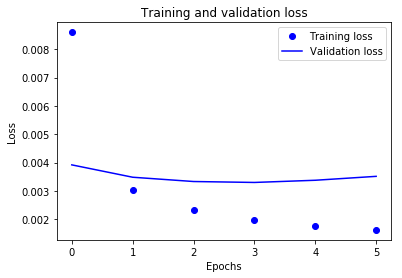

In [24]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']



plt.plot(range(len(loss_values)), loss_values, 'bo', label='Training loss')           
plt.plot(range(len(val_loss_values)), val_loss_values, 'b', label='Validation loss')      
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

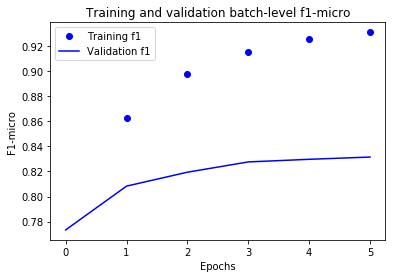

In [25]:
plt.clf()    

f1_values = history_dict['f1']
val_f1_values = history_dict['val_f1']

plt.plot(range(len(f1_values)), f1_values, 'bo', label='Training f1')
plt.plot(range(len(val_f1_values)), val_f1_values, 'b', label='Validation f1')
plt.title('Training and validation batch-level f1-micro')
plt.xlabel('Epochs')
plt.ylabel('F1-micro')
plt.legend()

plt.show()

### Save results arrays

In [26]:
def to_file(array,name):
    df = pd.DataFrame(data = array.tolist(),columns=[i for i in range(1,y_train.shape[1]+1)])
    df.to_csv(os.path.join(DATADIR, name+'.csv.gz'),compression='gzip',index=False)

In [27]:
y_prob = model.predict([meta_train, title_train, desc_train, x_train])

In [28]:
to_file(y_prob,"train_results")

In [29]:
y_pred = y_prob.copy()
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [30]:
print('micro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='weighted', sample_weight=None)))

micro: (0.96087221864845695, 0.95438341262663995, 0.95761682373576229, None)
macro: (0.97612390318920661, 0.97162071199874112, 0.97359360595384603, None)
weightedmacro: (0.96142540788192132, 0.95438341262663995, 0.95747751270259429, None)


In [31]:
y_prob_dev = model.predict([meta_dev, title_dev, desc_dev, x_dev])

In [32]:
to_file(y_prob_dev,"dev_results")

In [33]:
y_pred_dev = y_prob_dev.copy()
y_pred_dev[y_pred_dev>=P_THRESHOLD] = 1
y_pred_dev[y_pred_dev<P_THRESHOLD] = 0

In [34]:
print('micro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='weighted', sample_weight=None)))

micro: (0.84049357559291338, 0.82211272284353887, 0.83120154496347498, None)
macro: (0.80190499495089373, 0.85726866171762006, 0.82000987119737301, None)
weightedmacro: (0.84541911329588237, 0.82211272284353887, 0.83002450733175637, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [35]:
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average=None, sample_weight=None)))

weightedmacro: (array([ 1.        ,  0.88888889,  0.93965517,  0.5       ,  1.        ,
        0.61538462,  0.8       ,  0.70614035,  1.        ,  1.        ,
        0.99672489,  1.        ,  1.        ,  0.8372093 ,  1.        ,
        0.65789474,  1.        ,  0.75384615,  0.86468647,  0.85185185,
        0.83712121,  0.        ,  0.625     ,  1.        ,  1.        ,
        1.        ,  0.5       ,  0.93333333,  0.9375    ,  0.83333333,
        0.85714286,  0.        ,  0.59183673,  0.79253112,  0.5       ,
        0.81818182,  0.76129032,  0.8       ,  0.68181818,  0.        ,
        0.74418605,  0.78431373,  0.66666667,  0.99796126,  0.9       ,
        1.        ,  1.        ,  0.86956522,  0.75      ,  1.        ,
        1.        ,  0.76923077,  0.        ,  0.71428571,  1.        ,
        1.        ,  0.91958042,  0.64705882,  0.86567164,  0.78571429,
        0.        ,  0.8       ,  0.80487805,  1.        ,  0.81879195,
        0.78448276,  1.        ,  0.97468354,  0

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [36]:
to_file(y_train,"true_train")

In [37]:
to_file(y_dev,"true_dev")

### predictions

In [38]:
def get_predictions(data_to_tag): 
    filename = data_to_tag+"_arrays.npz"
    arrays = np.load(os.path.join(DATADIR,filename))
    
    print('Set up arrays for new_content: {}'.format(arrays.files))
    x_predict = arrays['x']
    meta_predict = arrays['meta'].all().todense()
    title_predict = arrays['title'].all().todense()
    desc_predict = arrays['desc'].all().todense()
    
    print('x_arrays.shape = {}'.format(x_predict.shape))
    print('meta_arrays.shape = {}'.format(meta_predict.shape))
    print('title_arrays.shape = {}'.format(title_predict.shape))
    print('desc_arrays.shape = {}'.format(desc_predict.shape))
    
    print('Predict on untagged content')
    y_pred_new = model.predict([meta_predict, title_predict, desc_predict, x_predict])
    
    to_file(y_pred_new, data_to_tag+"_predictions")

In [39]:
get_predictions("new")

Set up arrays for new_content: ['x', 'meta', 'title', 'desc', 'content_id']
x_arrays.shape = (68049, 1000)
meta_arrays.shape = (68049, 529)
title_arrays.shape = (68049, 10000)
desc_arrays.shape = (68049, 10000)
Predict on untagged content


In [40]:
get_predictions("level1")

Set up arrays for new_content: ['x', 'meta', 'title', 'desc', 'content_id']
x_arrays.shape = (18317, 1000)
meta_arrays.shape = (18317, 529)
title_arrays.shape = (18317, 10000)
desc_arrays.shape = (18317, 10000)
Predict on untagged content
